In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import K2fov
import numpy as np
%matplotlib inline
from tqdm import tqdm
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
plt.style.use('ggplot')

In [99]:
print('Downloading K2 candidate planets from NEXSCI...')
NEXSCI_API = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI'
k2 = pd.read_csv(NEXSCI_API + '?table=k2candidates&select=*'
                 '&where=k2c_disp+like+%27C%25%27')  # +and+k2c_recentflag=1
k2.to_csv('k2-candidate-planets.csv')
confirmed = k2.k2c_disp == 'CONFIRMED'

In [100]:
k2 = k2.drop_duplicates('epic_name')

In [101]:
def planetspercampaign(df):
    campaigns = np.arange(0, 18)
    nplanets = np.zeros(len(campaigns))
    
    for campaign in campaigns:
        ok = np.zeros(len(df), dtype=bool)
        for idx, k in enumerate(df.k2_campaign_str):
            try:
                ok[idx] = np.min(np.asarray(k.split(','), dtype=int)) == campaign
            except:
                continue
        nplanets[campaign] = len(df[ok])
    return campaigns, nplanets

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<Container object of 18 artists>

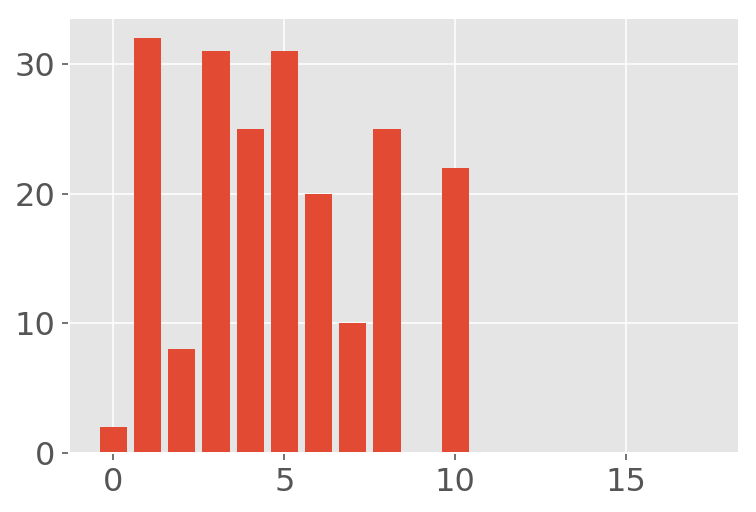

In [102]:
campaigns, nplanets = planetspercampaign(k2[confirmed])
plt.bar(campaigns, nplanets)

Some planets are missing from this list, e.g. after campaign 10. We can look at what MAST has for the confirmed planets. We'll take the maximum value in each campaign, assuming each service occasionally misses a planet:

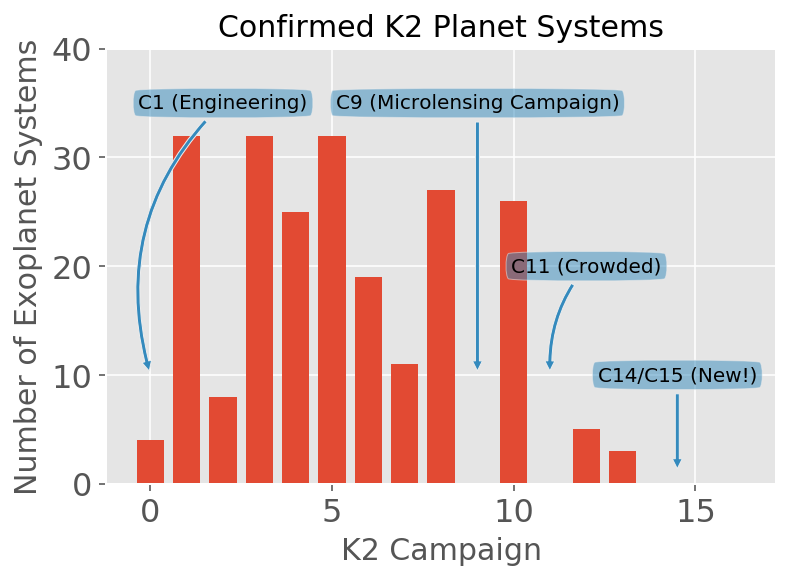

In [116]:
fig, ax = plt.subplots()
mast = pd.read_csv('https://archive.stsci.edu/k2/published_planets/search.php?&outputformat=CSV&action=Search', skiprows = [1])
mast = mast.drop_duplicates('K2 ID')
mast.loc[0:1, 'K2 Campaign'] = '0'


h = plt.hist(np.asarray(mast['K2 Campaign'], dtype=float), np.arange(0, 18, 1)-0.5, rwidth=0.75)
plt.xlabel('K2 Campaign', fontsize=15)
plt.ylabel('Number of Exoplanet Systems', fontsize=15);
plt.title('Confirmed K2 Planet Systems', fontsize=15)
plt.ylim(0,40 )

plt.savefig('charts/planetdiscoveries_1.png', dpi=300, bbox_inches='tight')
ann = ax.annotate("C1 (Engineering)",
                  xy=(0, 10), xycoords='data',
                  xytext=(2, 35), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0.3",
                                  fc="C1"), 
                  )
plt.savefig('charts/planetdiscoveries_2.png', dpi=300, bbox_inches='tight')

ann = ax.annotate("C9 (Microlensing Campaign)",
                  xy=(9, 10), xycoords='data',
                  xytext=(9, 35), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0",
                                  fc="C1"), 
                  )
plt.savefig('charts/planetdiscoveries_3.png', dpi=300, bbox_inches='tight')


ann = ax.annotate("C11 (Crowded)",
                  xy=(11, 10), xycoords='data',
                  xytext=(12, 20), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0.2",
                                  fc="C1"), 
                  )
plt.savefig('charts/planetdiscoveries_4.png', dpi=300, bbox_inches='tight')


ann = ax.annotate("C14/C15 (New!)",
                  xy=(14.5, 1), xycoords='data',
                  xytext=(14.5, 10), textcoords='data',
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="arc3, rad=0",
                                  fc="C1"), 
                  )
plt.savefig('charts/planetdiscoveries_5.png', dpi=300, bbox_inches='tight')



In [105]:
NEXSCI_API = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI'
df = pd.read_csv(NEXSCI_API + '?table=planets&select=pl_hostname,pl_letter,pl_disc,pl_discmethod,ra,dec,pl_trandep,pl_tranflag,pl_orbsmax,pl_radj,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_eqt,pl_orbper,pl_k2flag,pl_kepflag,pl_facility,st_rad,st_teff,st_optmag,st_j,st_h', comment='#')
df.to_csv('planets.csv')

df = df[df.pl_tranflag==1].reset_index(drop=True)

k2 = df[(df.pl_k2flag==1)&(df.pl_facility=='K2')].reset_index(drop=True)
kepler = df[(df.pl_kepflag==1)&(df.pl_facility=='Kepler')].reset_index(drop=True)
notk = df[(df.pl_kepflag==0) & (df.pl_k2flag==0) & (df.pl_discmethod=='Transit')]

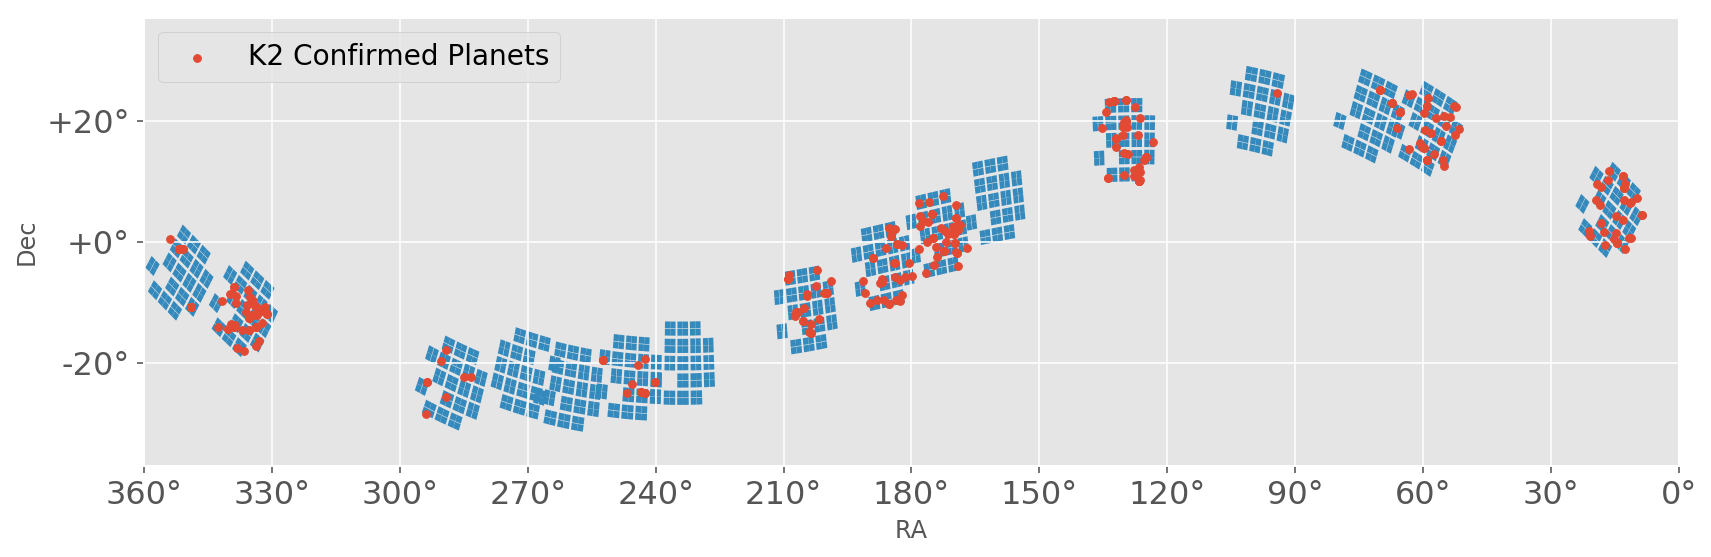

In [114]:
from K2fov import plot
CAMPAIGN = 0

p = plot.K2FootprintPlot(figsize=(12, 4))
for campaign in np.arange(0,16):
    p.plot_campaign(campaign, annotate_channels=False, facecolor='C1', lw=0, zorder=-1)
    
plt.scatter(k2.ra, k2.dec, c='C0', zorder=10, s=15, label='K2 Confirmed Planets')  
plt.legend()
plt.savefig('charts/planets_radec.png', dpi=300, bbox_inches='tight')

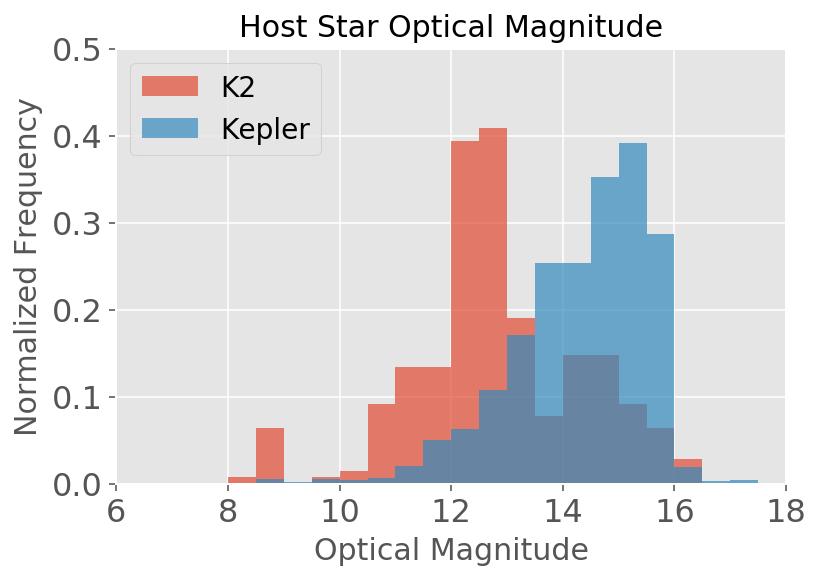

In [113]:
fig, ax = plt.subplots()
mag = k2.st_optmag
h = ax.hist(mag[np.isfinite(mag)], np.arange(5,20,0.5), normed=True, label='K2', alpha=0.7);
mag = kepler.st_optmag
_ = ax.hist(mag[np.isfinite(mag)], h[1], normed=True, label='Kepler', alpha=0.7);
ax.legend()
ax.set_ylabel('Normalized Frequency', fontsize=15)
ax.set_xlabel('Optical Magnitude', fontsize=15)
ax.set_title('Host Star Optical Magnitude', fontsize=15)
plt.ylim(0, 0.5)
plt.xlim(6, 18)
plt.savefig('charts/optical.png', dpi=300, bbox_inches='tight')



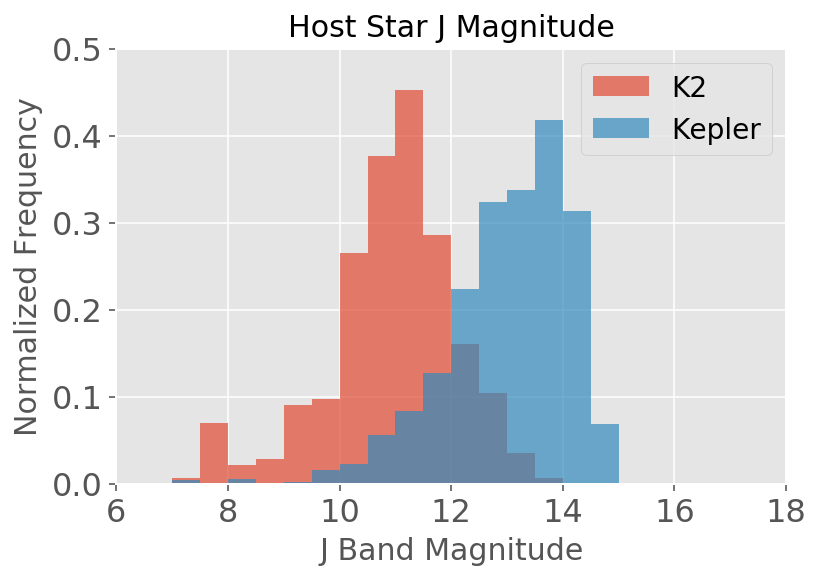

In [112]:
fig, ax = plt.subplots()
mag = k2.st_j
h = ax.hist(mag[np.isfinite(mag)], np.arange(5,20,0.5), normed=True, label='K2', alpha=0.7);
mag = kepler.st_j
_ = ax.hist(mag[np.isfinite(mag)], h[1], normed=True, label='Kepler', alpha=0.7);
ax.legend()
ax.set_ylabel('Normalized Frequency', fontsize=15)
ax.set_xlabel('J Band Magnitude', fontsize=15)
ax.set_title('Host Star J Magnitude', fontsize=15)
plt.ylim(0, 0.5)
plt.xlim(6, 18)
plt.savefig('charts/jband.png', dpi=300, bbox_inches='tight')



In [109]:
def planetsperyear(res = kepler):
    yrs, count = [], []
    for i in np.sort(np.unique(res.pl_disc)):
        yrs.append(i)
        count.append(len(res[res.pl_disc == i]))
    yrs = np.asarray(yrs)
    count = np.asarray(count)
    return yrs, count

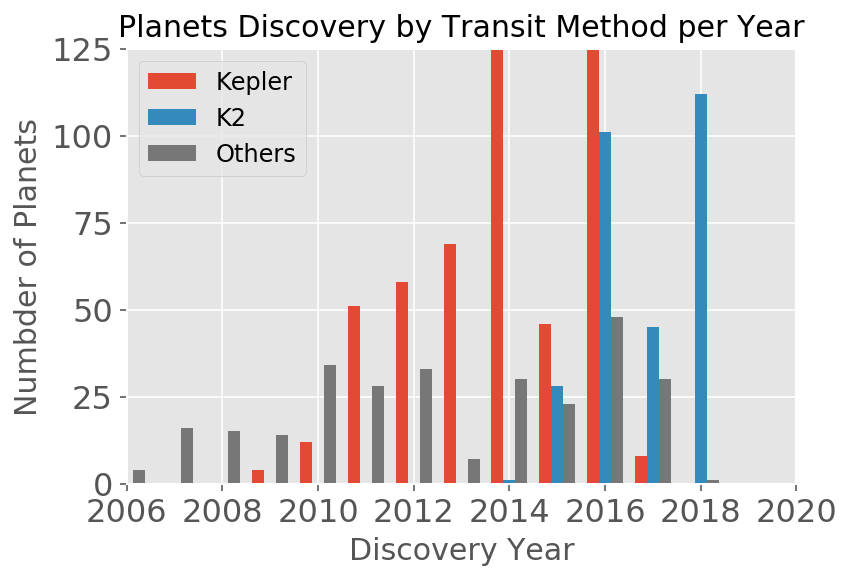

In [111]:
yrs, count = planetsperyear(kepler)
plt.bar(yrs-0.25, count, 0.25, label='Kepler')
yrs, count = planetsperyear(k2)
plt.bar(yrs, count, 0.25,  label='K2')
yrs, count = planetsperyear(notk)
plt.bar(yrs+0.25, count, 0.25, label='Others', color='C3')


plt.legend(fontsize=12)
plt.ylim(0,125)
plt.xlim(2006, 2019)
_ = plt.xticks(np.arange(2006,2022,2));
plt.xlabel('Discovery Year', fontsize=15)
plt.ylabel('Numbder of Planets', fontsize=15)
plt.title('Planets Discovery by Transit Method per Year', fontsize=15)

plt.savefig('charts/planetdiscoverys.png', dpi=300, bbox_inches='tight')